In [713]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from helper_func_diagnostics import plot_trace, calc_mape, calc_rmse, calc_median_ape

In [714]:
def calc_rmse_on_log_scale(g):
    rmse = np.sqrt(mean_squared_error(g['true'], g['pred']))
    return pd.Series(dict(rmse=np.log(rmse)))

In [715]:
# specify the model to be loaded
PATH_TO_RESULTS = "../results/"
MODELS_TO_ANALYSE = ["pred_base", "pred_horseshoe", "pred_gp"] # pred_gp
TRAINING_SET_SIZE = ["15", "20", "30", "40", "80", "120", "180"] # , "20", "30", "50", "80", "120", "180"
seed_list = [1348]

## Make prediction data frame

In [716]:
pred_dfs = []
runtime_dict = defaultdict(dict)
beta_sums = defaultdict(dict)
for seed in seed_list:
    for mod in MODELS_TO_ANALYSE:
        for n in TRAINING_SET_SIZE:
            final_path_to_pkl = PATH_TO_RESULTS + "fit_" + mod + "_" + n + "_" + str(seed) + ".pkl" # 
            with open(final_path_to_pkl, "rb") as f:
                data_dict = pickle.load(f)
                fit = data_dict['fit']
                y_hat = data_dict['y_hat']
                y_test = data_dict['y_test']
                X_test = data_dict['X_test']
                runtime = data_dict['runtime']
                summary_dict = fit.summary()
                sum_df = pd.DataFrame(summary_dict['summary'],
                                      columns=summary_dict['summary_colnames'],
                                      index=summary_dict['summary_rownames'])
                print("MAPE for model {}: ".format(mod), calc_mape(y_hat, y_test))
                # print("MAPE: ", calc_mape(np.exp(y_hat), np.exp(y_test)))
                df_pred = pd.DataFrame(np.vstack((y_test.ravel(), y_hat)).T, columns=["true", "pred"])
                df_pred["model"] = mod
                df_pred["n"] = int(n)
                df_pred["seed"] = seed
                pred_dfs.append(df_pred)
                runtime_dict[mod][n] = runtime
                # df_pred.index = X_test.index
                try:
                    betas = [sum_df.loc["beta[1,{}]".format(i+1)]["mean"] for i in range(X_test.shape[1])]
                    beta_sums[mod][n] = np.sum(np.abs(betas))
                    print("sum weights for model {} and size {} = ".format(mod, n), np.sum(np.abs(betas)))
                except:
                    pass

MAPE for model pred_base:  40.157309924130765
sum weights for model pred_base and size 15 =  15.059728403226668
MAPE for model pred_base:  15.459529647340657
sum weights for model pred_base and size 20 =  20.216065320369474
MAPE for model pred_base:  0.41312457294058685
sum weights for model pred_base and size 30 =  6.461593037546782
MAPE for model pred_base:  0.45472104743208946
sum weights for model pred_base and size 40 =  12.204272294808831
MAPE for model pred_base:  0.29862164058431784
sum weights for model pred_base and size 80 =  6.2221941379271195
MAPE for model pred_base:  0.3357920526560172
sum weights for model pred_base and size 120 =  5.959295856873485
MAPE for model pred_base:  0.28298083267156127
sum weights for model pred_base and size 180 =  4.542379677076882
MAPE for model pred_horseshoe:  1.7013922352481086
sum weights for model pred_horseshoe and size 15 =  26.458665914759948
MAPE for model pred_horseshoe:  1.2480518928081599
sum weights for model pred_horseshoe and

In [717]:
cmap = sns.color_palette("cubehelix", 8)
cmap = [cmap[0], cmap[5], cmap[6]]

In [718]:
beta_df = pd.DataFrame.from_dict({(i): beta_sums[i]
                           for i in beta_sums.keys()},
                       orient='index')

In [719]:
beta_df

,15,20,30,40,80,120,180
pred_base,15.059728,20.216065,6.461593,12.204272,6.222194,5.959296,4.542380
pred_horseshoe,26.458666,18.972451,5.476642,12.141435,6.213537,5.954282,4.526051


In [720]:
perf_df = []

In [756]:
runtime_df = pd.DataFrame.from_dict({(i): runtime_dict[i]
                           for i in runtime_dict.keys()},
                       orient='index')
runtime_df

,15,20,30,40,80,120,180
pred_base,49.184174,59.023243,61.530437,65.135269,98.127105,119.503087,173.317119
pred_horseshoe,42.436576,52.208850,56.039332,65.871870,94.331611,120.061425,169.747159
pred_gp,26.679537,31.838336,87.500574,177.604231,824.667681,2548.211516,8828.174705


In [757]:
runtime_df =  runtime_df.apply(lambda x: np.log(x))

In [753]:
runtime_df = runtime_df.T
# perf_df.append(runtime_df)

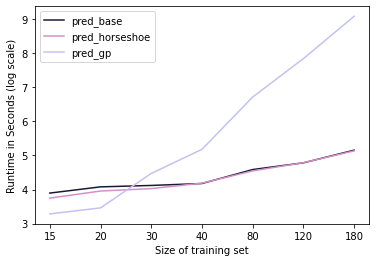

In [754]:
runtime_df.plot(color=cmap)
plt.ylabel("Runtime in Seconds (log scale)")
plt.xlabel("Size of training set")
plt.savefig("../figures/runtime_comp_models")
plt.show()

In [725]:
df = pd.concat(pred_dfs, axis=0)

In [726]:
err_df = df.groupby(["model", "n"]).apply(calc_rmse_on_log_scale)

In [727]:
err_df = pd.DataFrame(err_df).reset_index().pivot(index="n", columns="model", values="rmse")

In [728]:
err_df.index = err_df.index.astype(str)
perf_df.append(err_df)

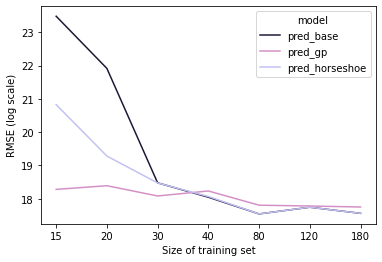

In [729]:
err_df.plot(xticks=range(len(err_df.index)), color=cmap)
plt.ylabel("RMSE (log scale)")
plt.xlabel("Size of training set")
plt.savefig("../figures/rmse_comp_models")

In [730]:
df["abs_error"] = np.abs(df.true - df.pred)
df["abs_perc_error"] = df.abs_error / df.true
df["sq_error"] = (df.true - df.pred)**2

In [731]:
err_df = df.groupby(["model", "n"])["abs_perc_error"].mean()
err_df = pd.DataFrame(err_df).reset_index()
err_df = err_df.pivot(index="n", columns="model", values="abs_perc_error")

In [732]:
err_df.index = err_df.index.astype(str)
perf_df.append(err_df)

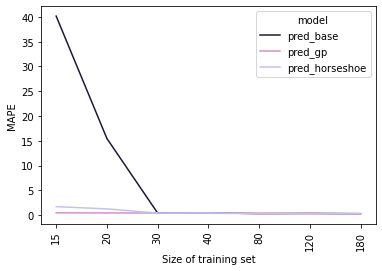

In [733]:
err_df.plot(xticks=range(len(err_df.index)), rot=90, color=cmap)
plt.ylabel("MAPE")
plt.xlabel("Size of training set")
plt.savefig("../figures/mape_comp_models")
plt.show()

In [734]:
perf_df = pd.concat(perf_df, axis=1, keys=["log RMSE", "MAPE"])

In [735]:
perf_df = perf_df.apply(lambda x: np.round(x, 2))

In [736]:
print(perf_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{log RMSE} & \multicolumn{3}{l}{MAPE} \\
model & pred\_base & pred\_gp & pred\_horseshoe & pred\_base & pred\_gp & pred\_horseshoe \\
n   &           &         &                &           &         &                \\
\midrule
15  &     23.48 &   18.28 &          20.82 &     40.16 &    0.45 &           1.70 \\
20  &     21.91 &   18.39 &          19.28 &     15.46 &    0.43 &           1.25 \\
30  &     18.48 &   18.08 &          18.47 &      0.41 &    0.41 &           0.41 \\
40  &     18.04 &   18.23 &          18.07 &      0.45 &    0.36 &           0.46 \\
80  &     17.54 &   17.80 &          17.54 &      0.30 &    0.33 &           0.30 \\
120 &     17.74 &   17.78 &          17.74 &      0.34 &    0.29 &           0.34 \\
180 &     17.56 &   17.75 &          17.56 &      0.28 &    0.26 &           0.28 \\
\bottomrule
\end{tabular}



## Visual analysis of posterior distribution

In [558]:
# specify the model to be loaded
PATH_TO_RESULTS = "../results/"
MODEL_TO_ANALYSE = "pred_gp"
TRAINING_SET_SIZE = "180" # , "20", "30", "50", "80", "120", "180"
SEED = 1348

In [559]:
final_path_to_pkl = PATH_TO_RESULTS + "fit_" + MODEL_TO_ANALYSE + "_" + TRAINING_SET_SIZE + "_" + str(seed) +  ".pkl"
with open(final_path_to_pkl, "rb") as f:
    data_dict = pickle.load(f)
    fit = data_dict['fit']
    y_hat = data_dict['y_hat']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    summary_dict = fit.summary()
    sum_df = pd.DataFrame(summary_dict['summary'],
                          columns=summary_dict['summary_colnames'],
                          index=summary_dict['summary_rownames'])

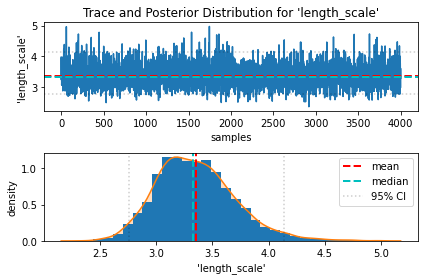

In [561]:
plot_trace(fit.extract()["length_scale"], "'length_scale'")
plt.savefig("../figures/posterior_length_scale.png")

# Analysis of beta coefficients in parametric regression

In [627]:
# specify the model to be loaded
PATH_TO_RESULTS = "../results/"
MODEL_TO_ANALYSE = "pred_base"
TRAINING_SET_SIZE = "180"
SEED = 412

In [628]:
final_path_to_pkl = PATH_TO_RESULTS + "fit_" + MODEL_TO_ANALYSE + "_" + TRAINING_SET_SIZE + "_" + str(SEED) +  ".pkl"
with open(final_path_to_pkl, "rb") as f:
    data_dict = pickle.load(f)
    fit = data_dict['fit']
    y_hat = data_dict['y_hat']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    summary_dict = fit.summary()
    sum_df = pd.DataFrame(summary_dict['summary'],
                          columns=summary_dict['summary_colnames'],
                          index=summary_dict['summary_rownames'])

In [629]:
coef_df = sum_df.loc[["beta[1,{}]".format(i+1) for i in range(X_test.shape[1])]]
coef_df.index = X_test.columns
coef_df["Mean/SD"] = coef_df["mean"] / coef_df["sd"] 
coef_df = coef_df[["mean", "sd", "Mean/SD", "Rhat"]]
coef_df.columns = ["Mean", "SD", "Mean/SD", "$\hat{R}$"]

In [630]:
coef_df

,Mean,SD,Mean/SD,$\hat{R}$
production_budget,0.213446,0.001141,187.087810,1.010543
dist,0.239863,0.002769,86.610974,1.008864
stars,-0.075764,0.003027,-25.030477,1.011646
direc,-0.291857,0.003687,-79.168161,1.011035
screens,0.495853,0.006131,80.872513,1.124037
opening_weekend_revenue,0.809676,0.001181,685.424683,1.000747
ratio_pos_tweets,-0.044009,0.006389,-6.888230,1.015851
total_tweets,0.007244,0.000959,7.551702,1.003432
adventure,-0.609750,0.004206,-144.978552,1.021754
comedy,-1.174276,0.005093,-230.547874,1.006859


In [631]:
print(coef_df.to_latex(index=True, bold_rows=True))  

\begin{tabular}{lrrrr}
\toprule
{} &      Mean &        SD &     Mean/SD &  \$\textbackslash hat\{R\}\$ \\
\midrule
\textbf{production\_budget      } &  0.213446 &  0.001141 &  187.087810 &   1.010543 \\
\textbf{dist                   } &  0.239863 &  0.002769 &   86.610974 &   1.008864 \\
\textbf{stars                  } & -0.075764 &  0.003027 &  -25.030477 &   1.011646 \\
\textbf{direc                  } & -0.291857 &  0.003687 &  -79.168161 &   1.011035 \\
\textbf{screens                } &  0.495853 &  0.006131 &   80.872513 &   1.124037 \\
\textbf{opening\_weekend\_revenue} &  0.809676 &  0.001181 &  685.424683 &   1.000747 \\
\textbf{ratio\_pos\_tweets       } & -0.044009 &  0.006389 &   -6.888230 &   1.015851 \\
\textbf{total\_tweets           } &  0.007244 &  0.000959 &    7.551702 &   1.003432 \\
\textbf{adventure              } & -0.609750 &  0.004206 & -144.978552 &   1.021754 \\
\textbf{comedy                 } & -1.174276 &  0.005093 & -230.547874 &   1.006859 \\
\textbf{

ValueError: not enough values to unpack (expected 2, got 1)

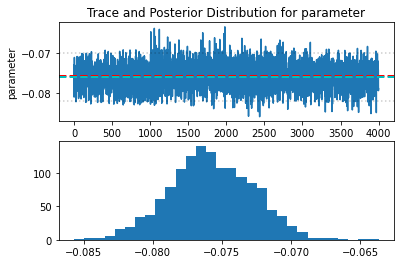

In [634]:
plot_trace(fit.extract()["beta"][:,:,2])

# Analysis of $\mu_\beta$

In [578]:
PATH_TO_RESULTS = "../results/"
MODEL_TO_ANALYSE = "pred_base"
TRAINING_SET_SIZE = "180"
SEED = 1348

In [579]:
final_path_to_pkl = PATH_TO_RESULTS + "fit_" + MODEL_TO_ANALYSE + "_" + TRAINING_SET_SIZE + "_" + str(SEED) +  ".pkl"
with open(final_path_to_pkl, "rb") as f:
    data_dict = pickle.load(f)
    fit = data_dict['fit']
    y_hat = data_dict['y_hat']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    summary_dict = fit.summary()
    sum_df = pd.DataFrame(summary_dict['summary'],
                          columns=summary_dict['summary_colnames'],
                          index=summary_dict['summary_rownames'])

In [580]:
coef_df = sum_df.loc[["mu_beta[{}]".format(i+1) for i in range(X_test.shape[1])]]

In [581]:
coef_df.index = X_test.columns
coef_df["Mean/SD"] = coef_df["mean"] / coef_df["sd"] 
coef_df = coef_df[["mean", "sd", "Mean/SD", "Rhat"]]
coef_df.columns = ["Mean", "SD", "Mean/SD", "$\hat{R}$"]

In [582]:
coef_df

,Mean,SD,Mean/SD,$\hat{R}$
production_budget,0.143841,1.362356,0.105582,22.112272
dist,-1.363194,0.529611,-2.573956,2.342765
stars,-0.229809,1.298211,-0.177020,20.735867
direc,-0.550113,1.348893,-0.407826,11.281642
screens,0.371198,0.794222,0.467374,9.333156
opening_weekend_revenue,0.678425,0.951702,0.712854,12.968035
ratio_pos_tweets,0.472755,0.700838,0.674557,15.491554
total_tweets,-0.443813,1.221221,-0.363417,20.692238
adventure,0.354436,0.631391,0.561357,9.401775
comedy,-0.108590,0.605520,-0.179333,6.721272
